<a href="https://colab.research.google.com/github/Pestrdan/netology_research/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B/TSML_14_HW2_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import numpy as np

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [ ]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

# **Стационарный ряд**

In [ ]:
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [ ]:
series_1 = female_births['Count']

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


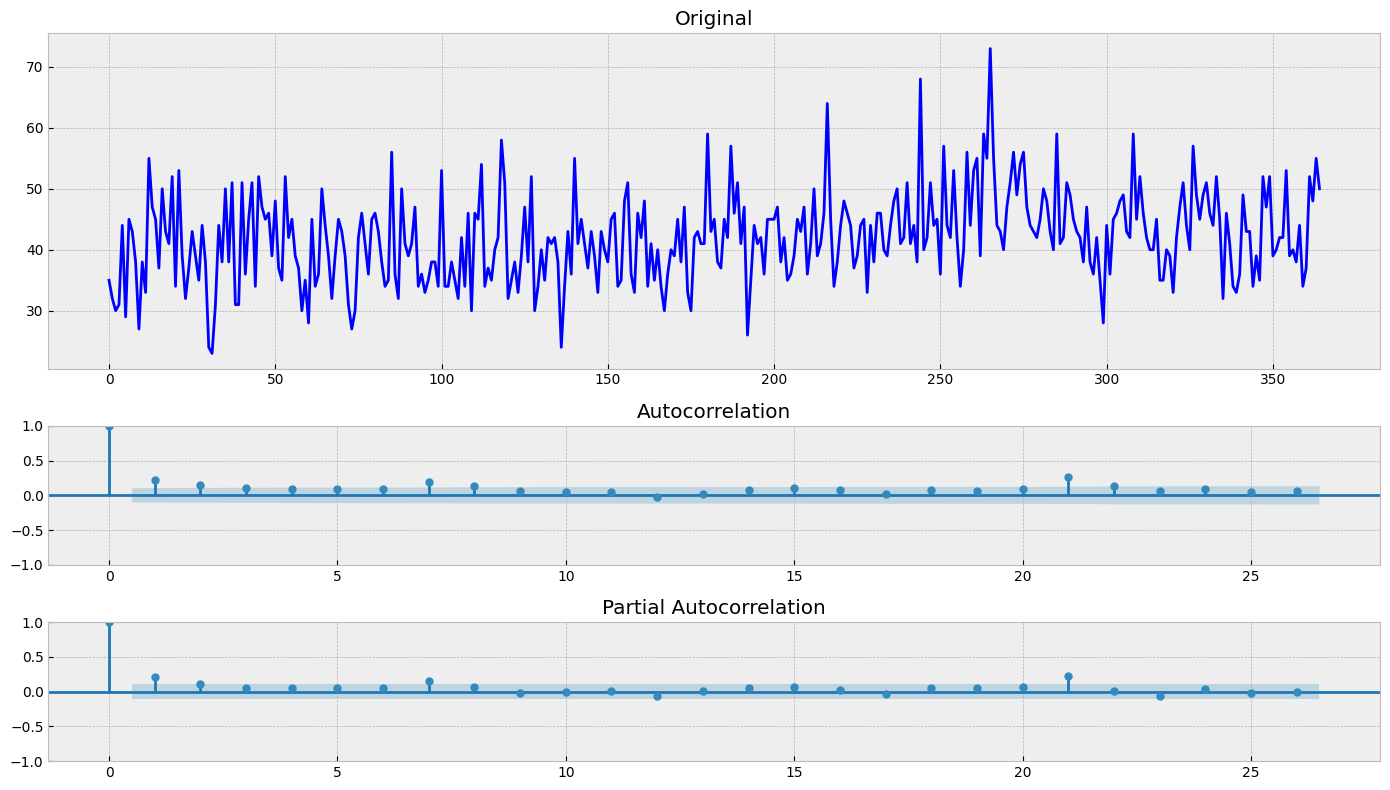

In [ ]:
tsplot(series_1)

**Так как ряд стационарен и по определению не обладает ни сезонностью, ни тренедом, то можно применить обычное скользящее среднее**

In [ ]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

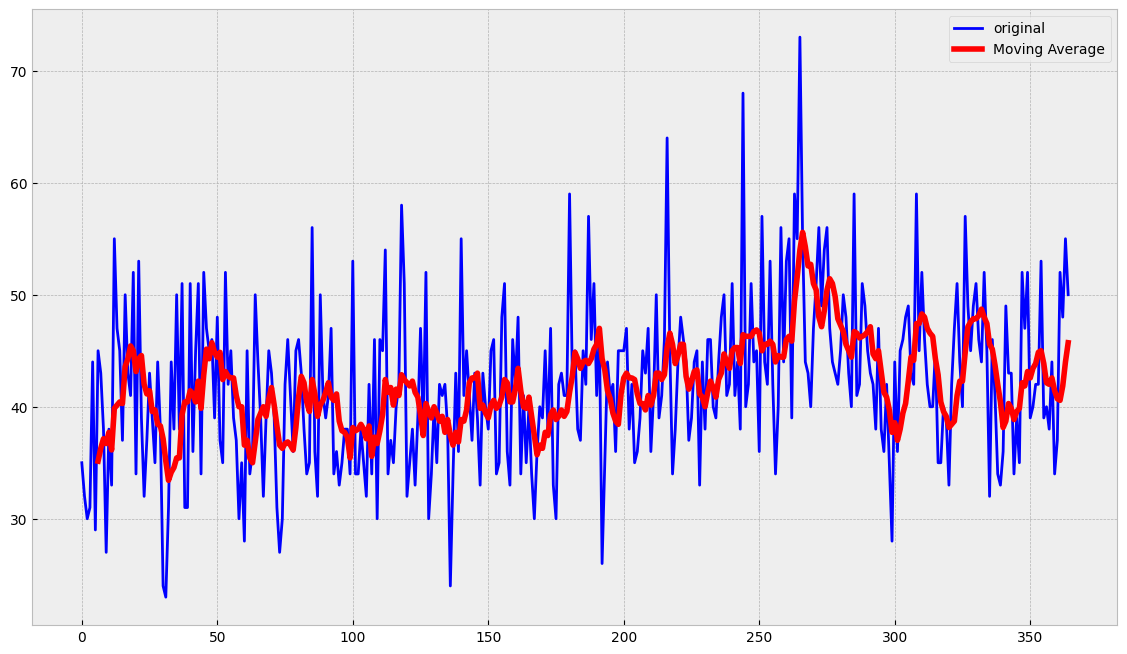

In [ ]:
ser_1 = moving_average(series_1, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_1, color='blue',label='original')
    plt.plot(ser_1, color='red', linewidth='4', label='Moving Average')
    plt.legend()

# **Не стационарный ряд**

In [ ]:
airlines_passengers = pd.read_csv("international-airline-passengers.csv")

In [ ]:
series = airlines_passengers['Count']

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


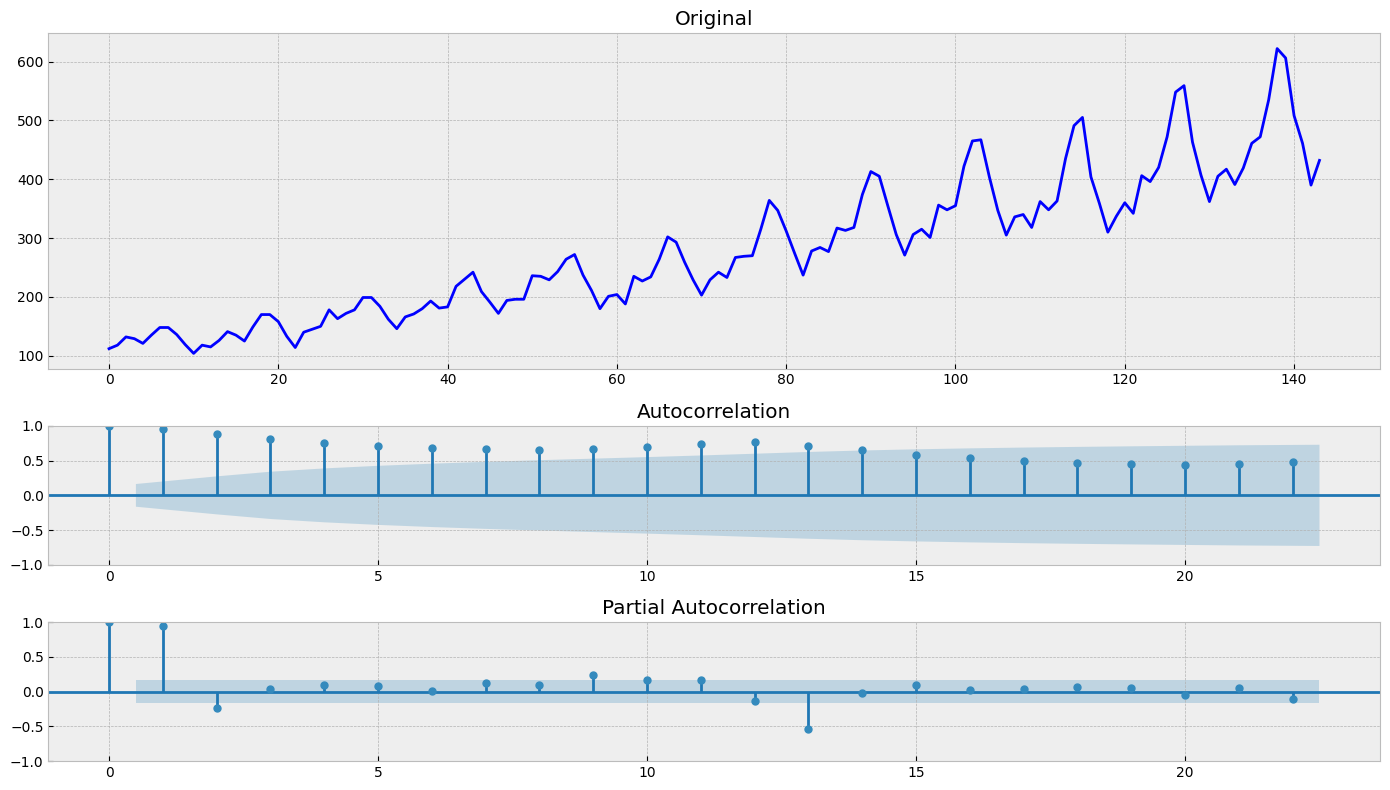

In [ ]:
tsplot(series)

**Ряд обладает как сезонностью. так и трендом. Используем тройное экспотенциальное среднее**

In [ ]:
def initial_trend(series, season_len):
    for i in range(season_len):
      return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [ ]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [ ]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [ ]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers['Count'], ser_to_plot=airlines_passengers['Count'], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

In [ ]:
train, val = series[:115], series[115:]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [ ]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="Nelder-Mead", bounds = ((0, 1), (0, 1), (0, 1)))

31514.5653755923------------
31104.62051893081------------
31514.5653755923------------
31480.49213979047------------
31217.933457873685------------
31022.48459824505------------
30780.731678485532------------
30596.211124653866------------
30168.07637170159------------
30157.398514313518------------
29647.44730642329------------
29321.794169400615------------
28487.86739417052------------
28151.97401520912------------
26964.756093884538------------
26665.10173417071------------
25144.414657669182------------
24375.238811812273------------
22273.166617963474------------
21608.344735482446------------
19123.417120649883------------
18303.086241899287------------
15584.656747217645------------
14576.888218196482------------
11894.078471221672------------
11149.891275297598------------
8897.795569921624------------
8234.21827021225------------
6552.112020374415------------
6085.862658058999------------
4950.4162956756------------
4665.721140290273------------
3949.024606645015------------

In [ ]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2983.8030874608544
             x: [ 5.142e-01  0.000e+00  0.000e+00]
           nit: 79
          nfev: 140
 final_simplex: (array([[ 5.142e-01,  0.000e+00,  0.000e+00],
                       [ 5.143e-01,  0.000e+00,  0.000e+00],
                       [ 5.142e-01,  0.000e+00,  0.000e+00],
                       [ 5.143e-01,  0.000e+00,  0.000e+00]]), array([ 2.984e+03,  2.984e+03,  2.984e+03,  2.984e+03]))


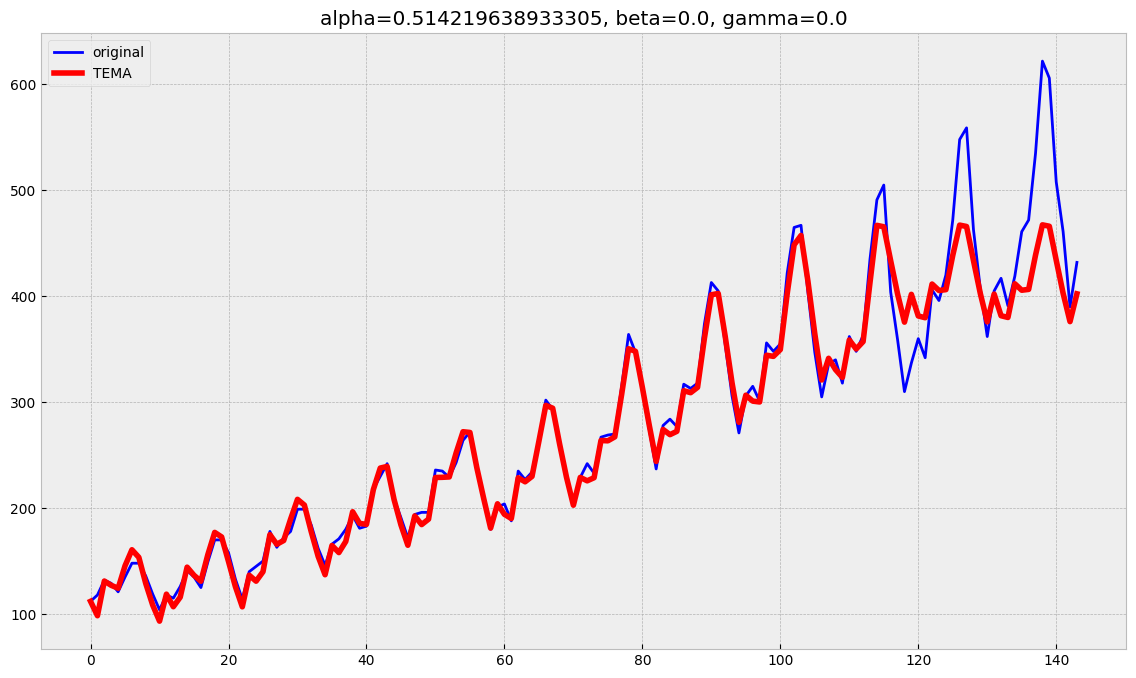

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val))